In [33]:
import numpy as np
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/C247_final_project/project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/C247_final_project/project


In [34]:
import numpy as np
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
import keras
X_test = np.load("X_test.npy")
y_test_1 = np.load("y_test.npy")  # changed from y_test
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

### Shape of data

https://www.bbci.de/competition/iv/desc_2a.pdf

In [35]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test_1.shape))  # changed from y_test
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
p_train=list(person_train_valid.reshape((person_train_valid.shape[0])))
p_test=list(person_test.reshape((person_test.shape[0])))
subject1tr=p_train.index(1)-1
subject1te=p_test.index(1)-1
subject1_x_train=X_train_valid[0:subject1tr+1].copy()
subject1_y_train=y_train_valid[0:subject1tr+1].copy()

subject1_x_test=X_test[0:subject1te+1].copy()
subject1_y_test=y_test_1[0:subject1te+1].copy()

y_train_valid -= 769
y_test_1 -= 769  # changed from y_test
subject1_y_train-=769
subject1_y_test-=769

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [36]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid, y_train_valid, 2, 2, True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [37]:
ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test_1,2,2,True)  # changed from y_test
subject1_x_train,subject1_y_train=data_prep(subject1_x_train,subject1_y_train,2,2,True)
subject1_x_test,subject1_y_test=data_prep(subject1_x_test,subject1_y_test,2,2,True)





print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)  # leave unchanged from y_test
subject1_y_train=to_categorical(subject1_y_train, 4)
subject1_y_test=to_categorical(subject1_y_test, 4)


print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
subject1_x_train = subject1_x_train.reshape(subject1_x_train.shape[0], subject1_x_train.shape[1], subject1_x_train.shape[2], 1)
subject1_x_test = subject1_x_test.reshape(subject1_x_test.shape[0], subject1_x_test.shape[1], subject1_x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
subject1_x_test = np.swapaxes(subject1_x_test, 1,3)
subject1_x_test = np.swapaxes(subject1_x_test, 1,2)
subject1_x_train = np.swapaxes(subject1_x_train, 1,3)
subject1_x_train = np.swapaxes(subject1_x_train, 1,2)

print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of X after trimming: (199, 22, 500)
Shape of X after maxpooling: (199, 22, 250)
Shape of X after averaging+noise and concatenating: (398, 22, 250)
Shape of X after subsampling and concatenating: (796, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatena

In [38]:
# https://arxiv.org/pdf/1703.05051.pdf

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [40]:
head_size = 128
num_heads = 16
dropout  = 0.55

In [41]:
inputs = layers.Input(shape=(250, 1, 22))

x = layers.Conv2D(filters=50,  kernel_size=(10,1), activation="elu", padding="same")(inputs)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=75,  kernel_size=(10,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=100,  kernel_size=(10,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=150, kernel_size=(3,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=200, kernel_size=(3,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(10,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)

x = layers.MultiHeadAttention(
    key_dim   = head_size,
    num_heads = num_heads,
    dropout   = 0.6
)(x, x)

x = layers.GlobalMaxPool2D()(x)
softmax_output = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs, softmax_output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 250, 1, 50)   11050       ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_19 (MaxPooling2D  (None, 84, 1, 50)   0           ['conv2d_20[0][0]']              
 )                                                                                                
                                                                                            

In [42]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="weights.hdf5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
history_transformer = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, batch_size=64, callbacks=[model_checkpoint_callback])

Epoch 1/100
105/109 [===========================>..] - ETA: 0s - loss: 1.7252 - accuracy: 0.2549
Epoch 1: val_accuracy improved from -inf to 0.28267, saving model to weights.hdf5
109/109 [==============================] - 7s 17ms/step - loss: 1.7192 - accuracy: 0.2543 - val_loss: 1.3845 - val_accuracy: 0.2827
Epoch 2/100
104/109 [===========================>..] - ETA: 0s - loss: 1.4444 - accuracy: 0.2562
Epoch 2: val_accuracy did not improve from 0.28267
109/109 [==============================] - 1s 10ms/step - loss: 1.4433 - accuracy: 0.2552 - val_loss: 1.3954 - val_accuracy: 0.2493
Epoch 3/100
107/109 [============================>.] - ETA: 0s - loss: 1.3780 - accuracy: 0.3037
Epoch 3: val_accuracy did not improve from 0.28267
109/109 [==============================] - 1s 11ms/step - loss: 1.3770 - accuracy: 0.3046 - val_loss: 1.3827 - val_accuracy: 0.2660
Epoch 4/100
109/109 [==============================] - ETA: 0s - loss: 1.3614 - accuracy: 0.3231
Epoch 4: val_accuracy improved f

In [43]:
model.load_weights("weights.hdf5")

In [44]:
model.evaluate(x_test, y_test)

56/56 [==============================] - 0s 4ms/step - loss: 0.9048 - accuracy: 0.7060


[0.9048148989677429, 0.705981969833374]

In [45]:
transoformer_eval_subject1=model.evaluate(subject1_x_test,subject1_y_test)

7/7 [==============================] - 0s 4ms/step - loss: 1.0338 - accuracy: 0.6100


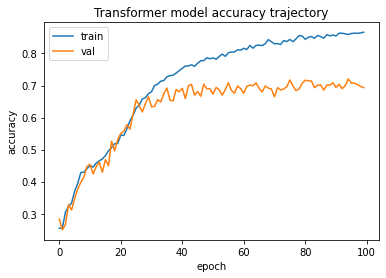

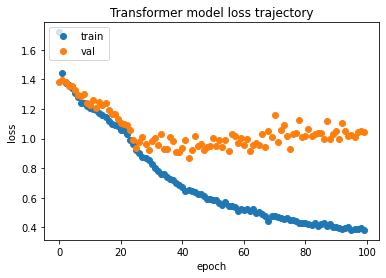

In [46]:
import matplotlib.pyplot as plt

plt.plot(history_transformer.history['accuracy'])
plt.plot(history_transformer.history['val_accuracy'])
plt.title('Transformer model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history_transformer.history['loss'],'o')
plt.plot(history_transformer.history['val_loss'],'o')
plt.title('Transformer model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
inputs = layers.Input(shape=(250, 1, 22))

x = layers.Conv2D(filters=50,  kernel_size=(10,1), activation="elu", padding="same")(inputs)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=75,  kernel_size=(10,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=100,  kernel_size=(10,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=150, kernel_size=(3,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=200, kernel_size=(3,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(10,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)

x = layers.MultiHeadAttention(
    key_dim   = head_size,
    num_heads = num_heads,
    dropout   = 0.6
)(x, x)

x = layers.GlobalMaxPool2D()(x)
softmax_output = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs, softmax_output)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 250, 1, 50)   11050       ['input_7[0][0]']                
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 84, 1, 50)   0           ['conv2d_25[0][0]']              
 )                                                                                                
                                                                                            

In [48]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
history_transformer = model.fit(subject1_x_train, subject1_y_train, validation_split=0.2, epochs=100, batch_size=64)

Epoch 1/100
10/10 [==============================] - 6s 64ms/step - loss: 1.7761 - accuracy: 0.2720 - val_loss: 3.2462 - val_accuracy: 0.2500
Epoch 2/100
10/10 [==============================] - 0s 21ms/step - loss: 1.9416 - accuracy: 0.2390 - val_loss: 2.0024 - val_accuracy: 0.2562
Epoch 3/100
10/10 [==============================] - 0s 23ms/step - loss: 1.8878 - accuracy: 0.2594 - val_loss: 2.2974 - val_accuracy: 0.2875
Epoch 4/100
10/10 [==============================] - 0s 20ms/step - loss: 1.7951 - accuracy: 0.2484 - val_loss: 3.5268 - val_accuracy: 0.2500
Epoch 5/100
10/10 [==============================] - 0s 18ms/step - loss: 1.7377 - accuracy: 0.2704 - val_loss: 2.0469 - val_accuracy: 0.2438
Epoch 6/100
10/10 [==============================] - 0s 15ms/step - loss: 1.6268 - accuracy: 0.2893 - val_loss: 2.1950 - val_accuracy: 0.2812
Epoch 7/100
10/10 [==============================] - 0s 15ms/step - loss: 1.5837 - accuracy: 0.2862 - val_loss: 1.7083 - val_accuracy: 0.2562
Epoch 

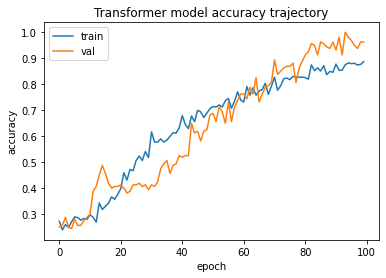

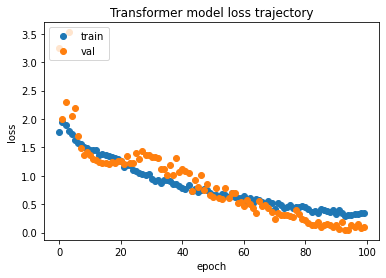

In [49]:
import matplotlib.pyplot as plt

plt.plot(history_transformer.history['accuracy'])
plt.plot(history_transformer.history['val_accuracy'])
plt.title('Transformer model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history_transformer.history['loss'],'o')
plt.plot(history_transformer.history['val_loss'],'o')
plt.title('Transformer model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
s_subject1 = model.evaluate(subject1_x_test, subject1_y_test)

7/7 [==============================] - 0s 4ms/step - loss: 1.5954 - accuracy: 0.6050


In [51]:
dropout  = 0.5

In [52]:
inputs = layers.Input(shape=(250, 1, 22))
x= layers.Conv2D(filters=30, kernel_size=(8,1), padding='same', activation='elu')(inputs)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Conv2D(filters=60, kernel_size=(8,1), padding='same', activation='elu')(x)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Conv2D(filters=90, kernel_size=(8,1), padding='same', activation='elu')(x)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Conv2D(filters=180, kernel_size=(8,1), padding='same', activation='elu')(x)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Flatten()(x)
softmax_output = layers.Dense(4, activation="softmax", activity_regularizer=tf.keras.regularizers.L2(0.1))(x)

cnn = keras.Model(inputs, softmax_output)
cnn.summary()







Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 250, 1, 22)]      0         
                                                                 
 conv2d_30 (Conv2D)          (None, 250, 1, 30)        5310      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 84, 1, 30)        0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 84, 1, 30)        120       
 chNormalization)                                                
                                                                 
 dropout_29 (Dropout)        (None, 84, 1, 30)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 84, 1, 60)         1446

In [53]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="weights_cnn.hdf5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

cnn.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
cnn_history = cnn.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, batch_size=64,callbacks=[model_checkpoint_callback])


Epoch 1/100
107/109 [============================>.] - ETA: 0s - loss: 1.9881 - accuracy: 0.3115
Epoch 1: val_accuracy improved from -inf to 0.37400, saving model to weights_cnn.hdf5
109/109 [==============================] - 4s 11ms/step - loss: 1.9853 - accuracy: 0.3119 - val_loss: 1.4970 - val_accuracy: 0.3740
Epoch 2/100
108/109 [============================>.] - ETA: 0s - loss: 1.5847 - accuracy: 0.3682
Epoch 2: val_accuracy improved from 0.37400 to 0.43267, saving model to weights_cnn.hdf5
109/109 [==============================] - 1s 8ms/step - loss: 1.5845 - accuracy: 0.3680 - val_loss: 1.3328 - val_accuracy: 0.4327
Epoch 3/100
109/109 [==============================] - ETA: 0s - loss: 1.3526 - accuracy: 0.4338
Epoch 3: val_accuracy did not improve from 0.43267
109/109 [==============================] - 1s 8ms/step - loss: 1.3526 - accuracy: 0.4338 - val_loss: 1.4128 - val_accuracy: 0.3407
Epoch 4/100
106/109 [============================>.] - ETA: 0s - loss: 1.2499 - accuracy:

In [54]:
cnn.load_weights("weights_cnn.hdf5")
s = cnn.evaluate(x_test, y_test)



56/56 [==============================] - 0s 4ms/step - loss: 0.9291 - accuracy: 0.7077


In [55]:
cnn_subject1=cnn.evaluate(subject1_x_test,subject1_y_test)

7/7 [==============================] - 0s 5ms/step - loss: 1.0683 - accuracy: 0.6400


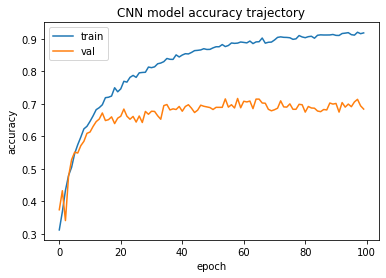

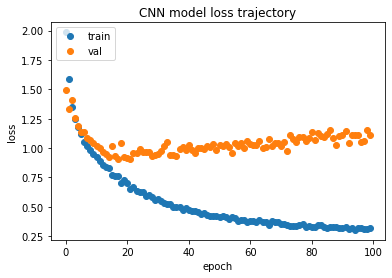

In [56]:
import matplotlib.pyplot as plt

plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_history.history['loss'],'o')
plt.plot(cnn_history.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
dropout = 0.5

In [58]:
inputs = layers.Input(shape=(250, 1, 22))
x= layers.Conv2D(filters=30, kernel_size=(8,1), padding='same', activation='elu')(inputs)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Conv2D(filters=60, kernel_size=(8,1), padding='same', activation='elu')(x)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Conv2D(filters=90, kernel_size=(8,1), padding='same', activation='elu')(x)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Conv2D(filters=180, kernel_size=(8,1), padding='same', activation='elu')(x)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Flatten()(x)
softmax_output = layers.Dense(4, activation="softmax", activity_regularizer=tf.keras.regularizers.L2(0.01))(x)

cnn2 = keras.Model(inputs, softmax_output)
cnn2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 250, 1, 22)]      0         
                                                                 
 conv2d_34 (Conv2D)          (None, 250, 1, 30)        5310      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 84, 1, 30)        0         
 g2D)                                                            
                                                                 
 batch_normalization_34 (Bat  (None, 84, 1, 30)        120       
 chNormalization)                                                
                                                                 
 dropout_33 (Dropout)        (None, 84, 1, 30)         0         
                                                                 
 conv2d_35 (Conv2D)          (None, 84, 1, 60)         1446

In [59]:
cnn2.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
cnn_history_subject1 = cnn2.fit(subject1_x_train, subject1_y_train, validation_split=0.2, epochs=100, batch_size=64)



Epoch 1/100
10/10 [==============================] - 4s 35ms/step - loss: 2.2158 - accuracy: 0.2862 - val_loss: 7.2432 - val_accuracy: 0.2500
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.9930 - accuracy: 0.3601 - val_loss: 6.1008 - val_accuracy: 0.2500
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 1.7179 - accuracy: 0.4450 - val_loss: 3.7892 - val_accuracy: 0.3187
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - loss: 1.6839 - accuracy: 0.4796 - val_loss: 3.2274 - val_accuracy: 0.3313
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.6371 - accuracy: 0.4418 - val_loss: 3.5907 - val_accuracy: 0.3063
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4189 - accuracy: 0.4890 - val_loss: 3.3154 - val_accuracy: 0.3125
Epoch 7/100
10/10 [==============================] - 0s 12ms/step - loss: 1.2760 - accuracy: 0.5425 - val_loss: 2.7927 - val_accuracy: 0.3187
Epoch 

In [60]:
s_subject1 = cnn2.evaluate(subject1_x_test, subject1_y_test)

7/7 [==============================] - 0s 5ms/step - loss: 2.1865 - accuracy: 0.6750


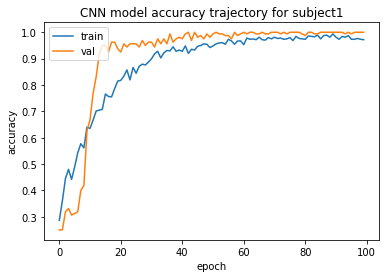

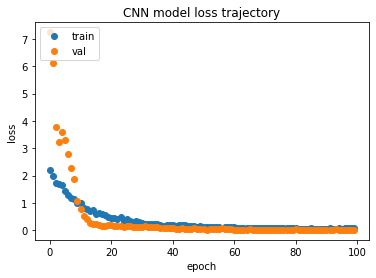

In [61]:
plt.plot(cnn_history_subject1.history['accuracy'])
plt.plot(cnn_history_subject1.history['val_accuracy'])
plt.title('CNN model accuracy trajectory for subject1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_history_subject1.history['loss'],'o')
plt.plot(cnn_history_subject1.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [62]:
dropout = 0.6

In [63]:
inputs = layers.Input(shape=(250, 1, 22))

x = layers.Conv2D(filters=25,  kernel_size=(10,1), activation="elu", padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=50,  kernel_size=(10,1), activation="elu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=(10,1))(x)
x = layers.Dropout(dropout)(x)
x = layers.Reshape(target_shape=(25,50))(x)
x = layers.LSTM(128, recurrent_dropout=dropout, return_sequences=True)(x)
x = layers.LSTM(256, recurrent_dropout=dropout)(x)
x = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, x)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 250, 1, 22)]      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 batch_normalization_38 (Bat  (None, 250, 1, 25)       100       
 chNormalization)                                                
                                                                 
 conv2d_39 (Conv2D)          (None, 250, 1, 50)        12550     
                                                                 
 batch_normalization_39 (Bat  (None, 250, 1, 50)       200       
 chNormalization)                                                
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 25, 1, 50)        0   

In [64]:
import time

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="weights_lstm.hdf5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

start = time.time()
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])
lstm_history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, batch_size=64, callbacks=[model_checkpoint_callback])
end = time.time()
wall_time_lstm = end - start

Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 1.3752 - accuracy: 0.2871
Epoch 1: val_accuracy improved from -inf to 0.36267, saving model to weights_lstm.hdf5
109/109 [==============================] - 28s 200ms/step - loss: 1.3752 - accuracy: 0.2871 - val_loss: 1.3410 - val_accuracy: 0.3627
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 1.3241 - accuracy: 0.3609
Epoch 2: val_accuracy improved from 0.36267 to 0.39867, saving model to weights_lstm.hdf5
109/109 [==============================] - 23s 211ms/step - loss: 1.3241 - accuracy: 0.3609 - val_loss: 1.2729 - val_accuracy: 0.3987
Epoch 3/100
109/109 [==============================] - ETA: 0s - loss: 1.2446 - accuracy: 0.4239
Epoch 3: val_accuracy improved from 0.39867 to 0.45400, saving model to weights_lstm.hdf5
109/109 [==============================] - 23s 213ms/step - loss: 1.2446 - accuracy: 0.4239 - val_loss: 1.2717 - val_accuracy: 0.4540
Epoch 4/100
109/109 [===================

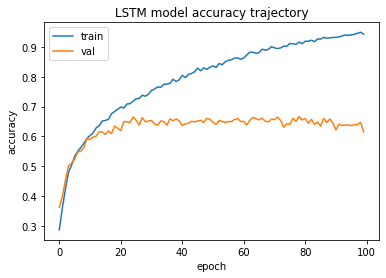

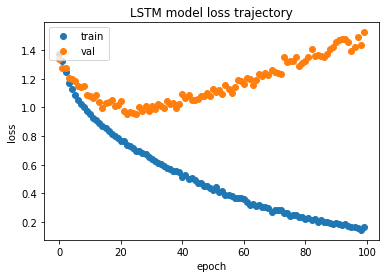

In [65]:
import matplotlib.pyplot as plt

plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(lstm_history.history['loss'],'o')
plt.plot(lstm_history.history['val_loss'],'o')
plt.title('LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [66]:
model.load_weights("weights_lstm.hdf5")

In [67]:
lstm_eval = model.evaluate(x_test, y_test)


56/56 [==============================] - 1s 18ms/step - loss: 1.4229 - accuracy: 0.6377


In [68]:
lstm_subject1=model.evaluate(subject1_x_test,subject1_y_test)

7/7 [==============================] - 0s 20ms/step - loss: 1.6562 - accuracy: 0.5400


In [69]:
inputs = layers.Input(shape=(250, 1, 22))

x = layers.Conv2D(filters=25,  kernel_size=(10,1), activation="elu", padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=50,  kernel_size=(10,1), activation="elu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=(10,1))(x)
x = layers.Dropout(dropout)(x)
x = layers.Reshape(target_shape=(25,50))(x)
x = layers.LSTM(128, recurrent_dropout=dropout, return_sequences=True)(x)
x = layers.LSTM(256, recurrent_dropout=dropout)(x)
x = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, x)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 250, 1, 22)]      0         
                                                                 
 conv2d_40 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 batch_normalization_40 (Bat  (None, 250, 1, 25)       100       
 chNormalization)                                                
                                                                 
 conv2d_41 (Conv2D)          (None, 250, 1, 50)        12550     
                                                                 
 batch_normalization_41 (Bat  (None, 250, 1, 50)       200       
 chNormalization)                                                
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 25, 1, 50)        0  

In [70]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])
lstm_history = model.fit(subject1_x_train, subject1_y_train, validation_split=0.2, epochs=100, batch_size=64)

Epoch 1/100
10/10 [==============================] - 9s 417ms/step - loss: 1.3906 - accuracy: 0.2437 - val_loss: 1.3942 - val_accuracy: 0.2188
Epoch 2/100
10/10 [==============================] - 2s 183ms/step - loss: 1.3783 - accuracy: 0.2830 - val_loss: 1.3859 - val_accuracy: 0.2625
Epoch 3/100
10/10 [==============================] - 2s 175ms/step - loss: 1.3734 - accuracy: 0.2940 - val_loss: 1.3733 - val_accuracy: 0.3313
Epoch 4/100
10/10 [==============================] - 2s 179ms/step - loss: 1.3587 - accuracy: 0.3255 - val_loss: 1.3638 - val_accuracy: 0.3438
Epoch 5/100
10/10 [==============================] - 2s 188ms/step - loss: 1.3397 - accuracy: 0.3742 - val_loss: 1.3747 - val_accuracy: 0.2625
Epoch 6/100
10/10 [==============================] - 2s 177ms/step - loss: 1.3265 - accuracy: 0.3962 - val_loss: 1.4040 - val_accuracy: 0.2625
Epoch 7/100
10/10 [==============================] - 3s 262ms/step - loss: 1.3003 - accuracy: 0.3962 - val_loss: 1.4441 - val_accuracy: 0.2562

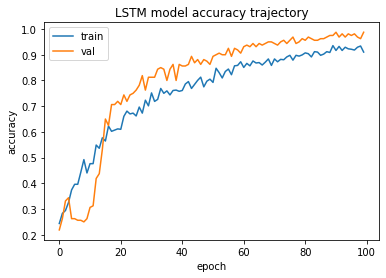

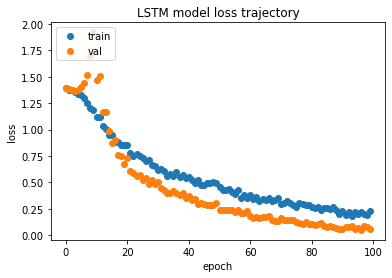

In [71]:
import matplotlib.pyplot as plt

plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(lstm_history.history['loss'],'o')
plt.plot(lstm_history.history['val_loss'],'o')
plt.title('LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [72]:
lstm_subject1_eval = model.evaluate(subject1_x_test, subject1_y_test)

7/7 [==============================] - 0s 19ms/step - loss: 1.2204 - accuracy: 0.6400
